['fho_lta_debug_val.json', 'fho_lta_taxonomy.json', 'fho_lta_test_unannotated.json', 'fho_lta_train.json', 'fho_lta_train_10000.json', 'fho_lta_train_5000.json', 'fho_lta_val.json']
  version    date                                        description  split  \
0     1.0  220217  Ego4d Long Term Anticipation Forecasting Annot...  train   

                                               clips  
0  [{'video_uid': '9c59e912-2340-4400-b2df-7db3d4...  
                               video_uid  \
0   9c59e912-2340-4400-b2df-7db3d4066723   
1   9c59e912-2340-4400-b2df-7db3d4066723   
2   9c59e912-2340-4400-b2df-7db3d4066723   
3   9c59e912-2340-4400-b2df-7db3d4066723   
4   9c59e912-2340-4400-b2df-7db3d4066723   
5   9c59e912-2340-4400-b2df-7db3d4066723   
6   9c59e912-2340-4400-b2df-7db3d4066723   
7   9c59e912-2340-4400-b2df-7db3d4066723   
8   9c59e912-2340-4400-b2df-7db3d4066723   
9   9c59e912-2340-4400-b2df-7db3d4066723   
10  9c59e912-2340-4400-b2df-7db3d4066723   
11  9c59e912-2340-440

Created column Counter: action_label
Created column Counter: action
344
We have 47.56886574074074 actions/video avgd over users
video_df=(9645, 54), labels_df=(23610, 20)
                               video_uid  \
0   002d2729-df71-438d-8396-5895b349e8fd   
1   01db7c39-a512-4bac-b284-dff8c7360e80   
2   02995fb6-f8ac-4168-a60d-8a0b1a7210bd   
3   05e8b510-0973-4cbd-9a23-bf2c156b7958   
4   05f672ea-1651-4767-9c8a-0f504805e9c7   
5   062ded0e-1df8-42d1-adaa-fc948e1cd7de   
6   078f6bad-aa22-48bf-9df2-4d2f6ba7b556   
7   080657b3-7f23-4285-96ec-39136e58cdf1   
8   0836e1a4-11e6-4b31-bd39-f8e083fdadb3   
9   099f6f96-5aa7-4da8-a5e0-2e8bc03beee6   
10  0b24eb9e-a5ae-4389-b2cd-11fbf88e9c4a   
11  0b6fc89d-bf4b-44f3-82e7-67ee02517459   
12  0be30efe-9d71-4698-8304-f1d441aeea58   
13  0c192ca8-1ede-4ef0-a05e-2f4151b6bdfc   
14  0c8c2f4b-a006-47ca-8826-133af1dfb632   
15  0cb2dd94-afb1-4e30-a62f-724f34d81777   
16  0d8a3e5c-4263-4f80-b32d-39d4f33008ba   
17  0e6fb738-05fc-4dd5-9746-a8e10efe8

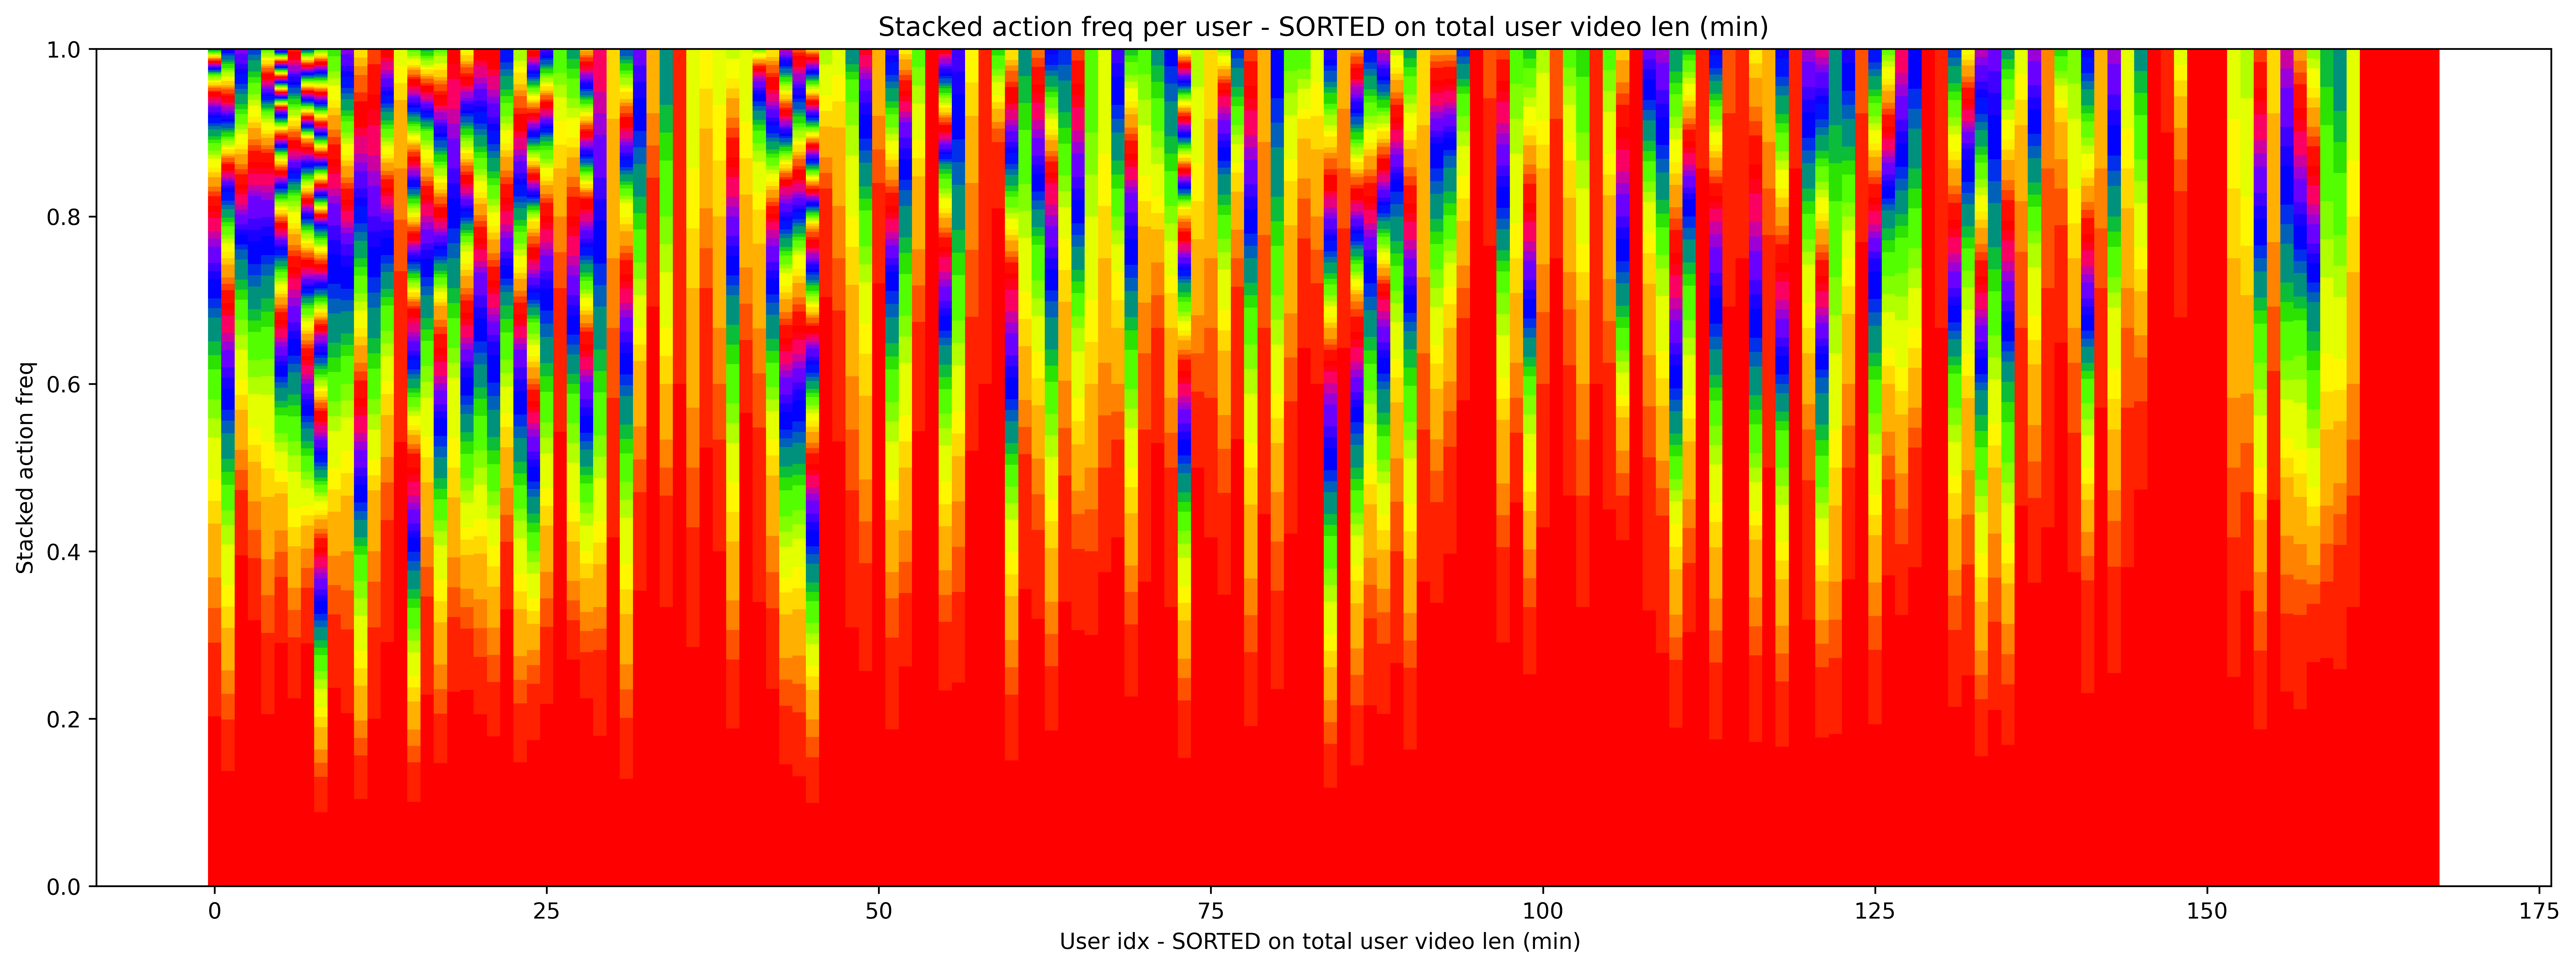

<Figure size 432x288 with 0 Axes>

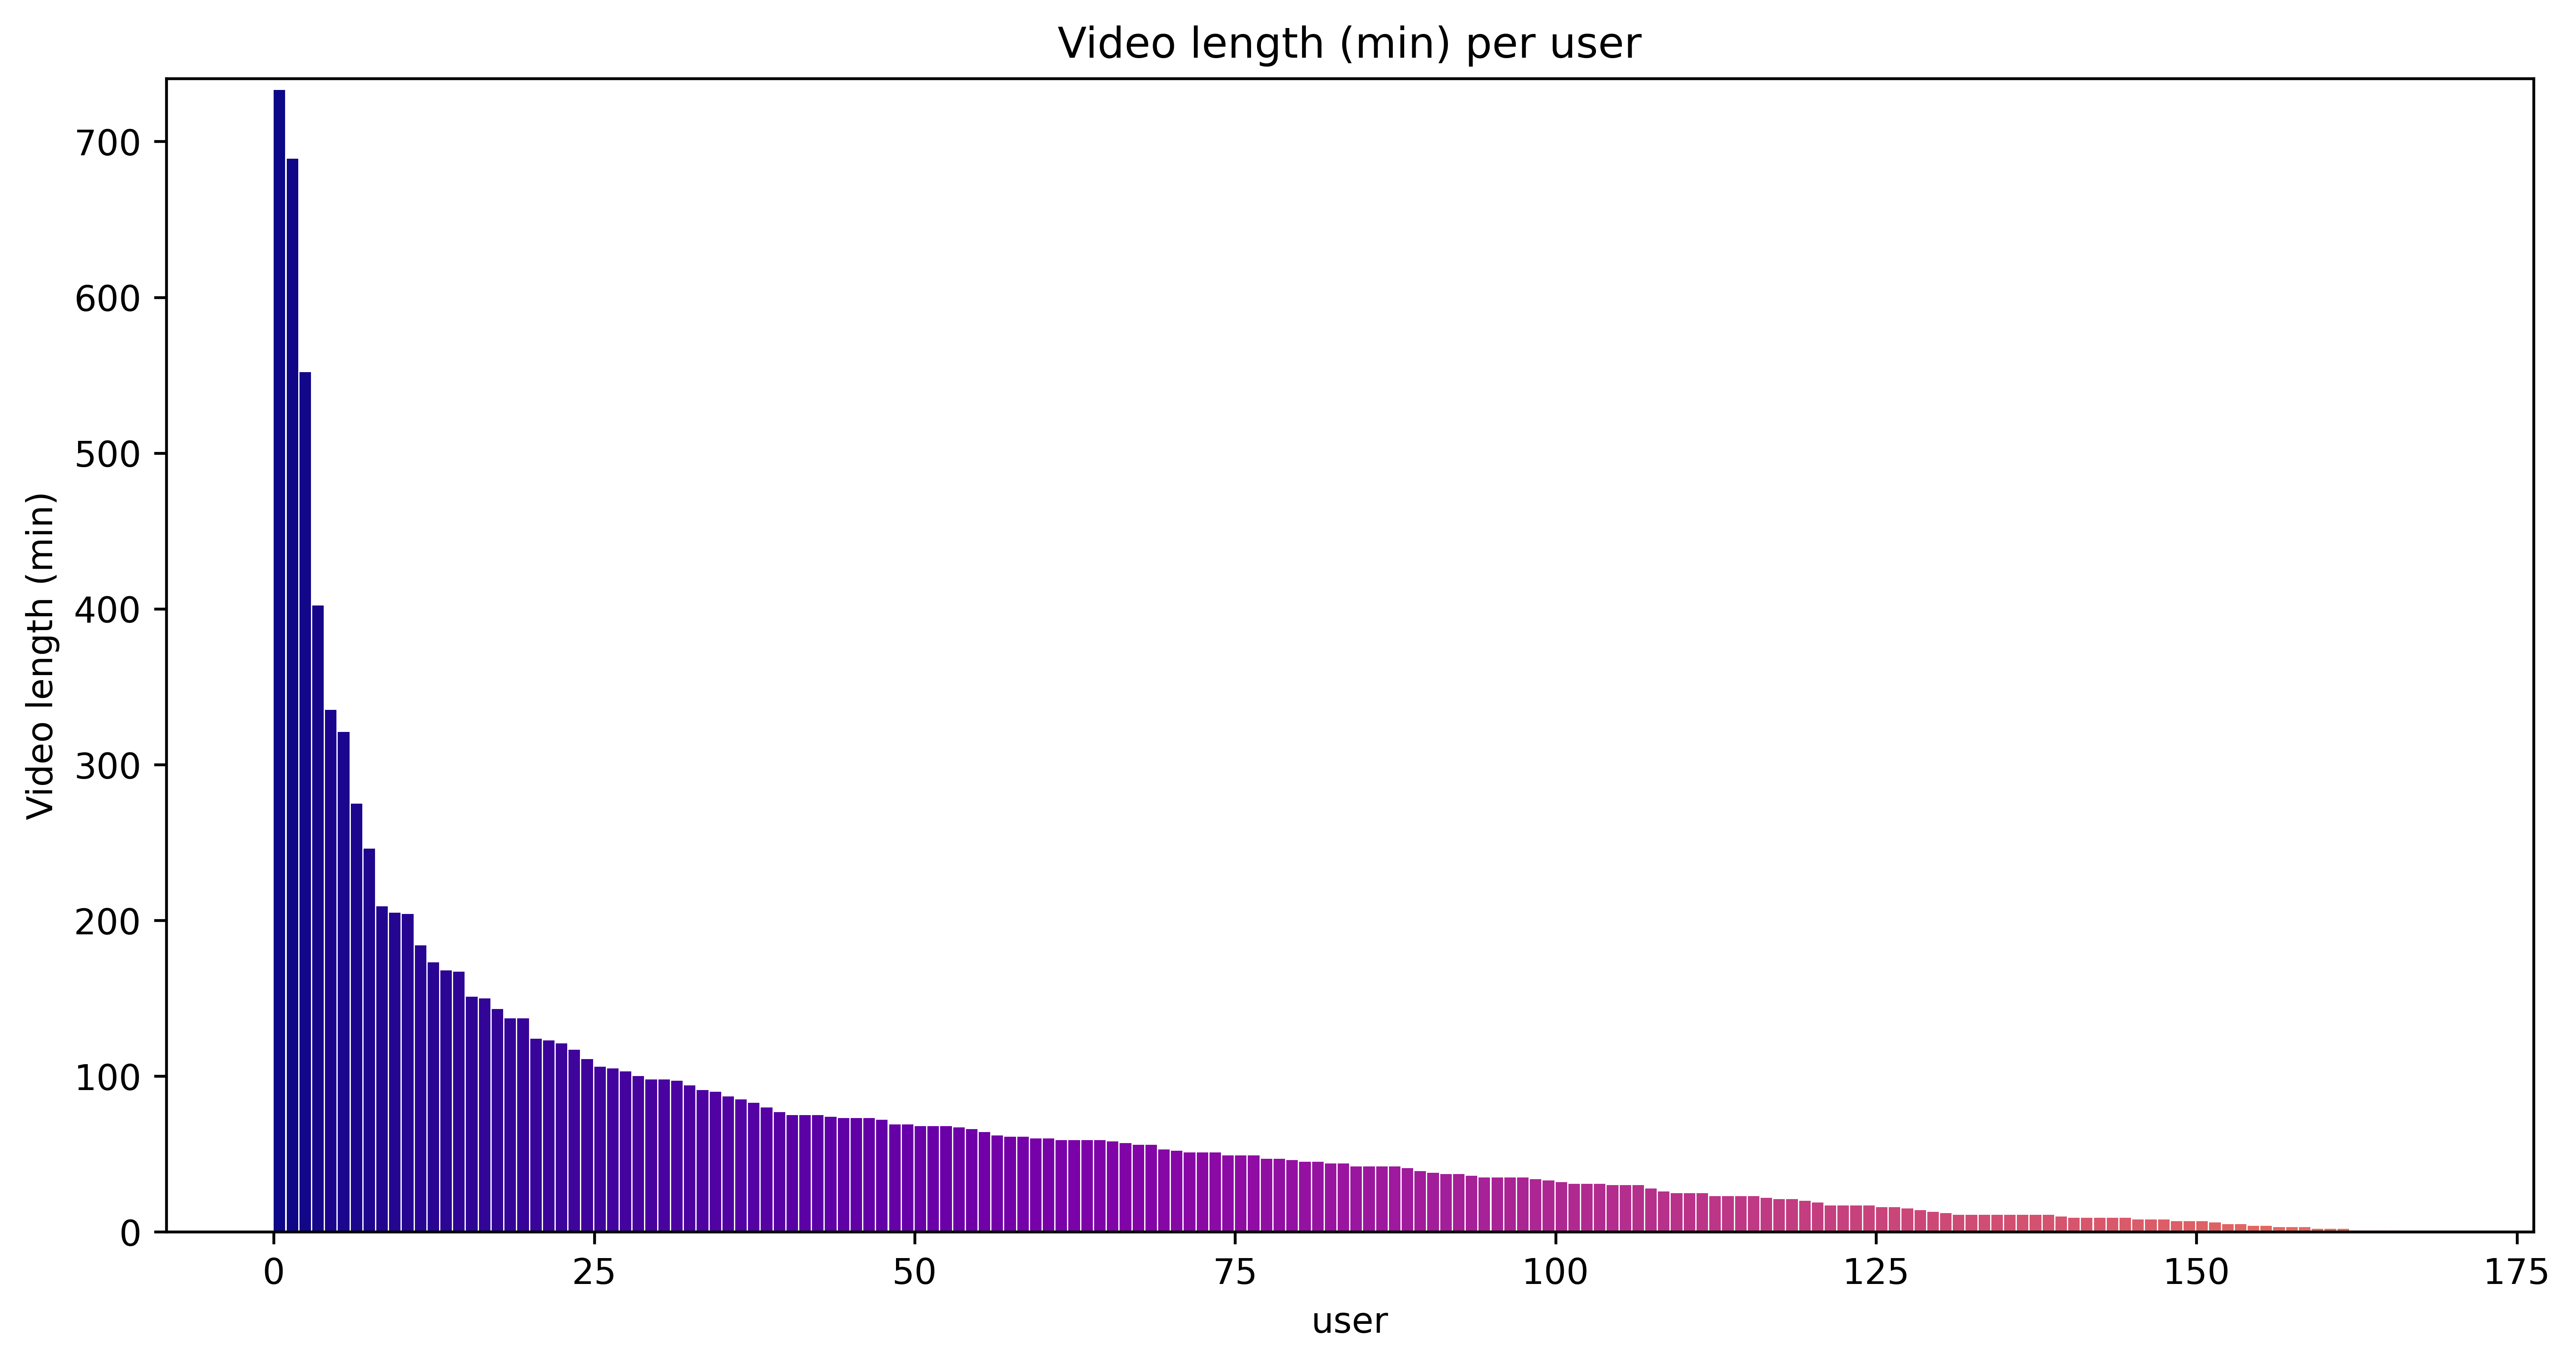

HEAD = [733, 689, 552, 402, 335, 321, 275, 246, 209, 205]...
TAIL = ...[3, 2, 2, 2, 1, 1, 1, 1, 0, 0]


<Figure size 432x288 with 0 Axes>

In [1]:
%run 'ego4d_user_vs_action_analysis.ipynb' # Should enable importing from other notebook

"""
This analysis is on the merged labeled train/val sets of the LTAA benchmark in ego4d.
Analysis in ego4d_user_vs_action_analysis.ipynb focuses on single splits instead.
"""
import pandas as pd
import numpy as np
from collections import Counter
import os.path as osp
import json
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)       


# Load train+validation sets

In [2]:
# CHECK CROSS-SPLITS: Are there mutually excl users in each split?
# Test has no labels
annotation_file_dir = "/fb-agios-acai-efs/Ego4D/ego4d_data/v1/annotations"
annotation_file_names = {'train':"fho_lta_train.json",'val':'fho_lta_val.json','test':'fho_lta_test_unannotated.json'}
with open(osp.join(annotation_file_dir, annotation_file_names['train']), 'r') as train_file, \
    open(osp.join(annotation_file_dir, annotation_file_names['val']), 'r') as val_file:
    train_clips = json.load(train_file)['clips']
    val_clips = json.load(val_file)['clips']

train_clips_df = pd.json_normalize(train_clips)
val_clips_df = pd.json_normalize(val_clips)
print(f"trainshape={train_clips_df.shape}")
print(f"valshape={val_clips_df.shape}")

train_joined_df = pd.merge(video_df, train_clips_df, on="video_uid",validate="one_to_many",how="inner") # Inner-join (Intersection of  video-uid values)
val_joined_df = pd.merge(video_df, val_clips_df, on="video_uid",validate="one_to_many",how="inner") # Inner-join (Intersection of  video-uid values)
print(f"train_joined_df={train_joined_df.shape}")
print(f"val_joined_df={val_joined_df.shape}")


train_user_df = group_innerjoin_by_user(train_joined_df)
val_user_df = group_innerjoin_by_user(val_joined_df)
print(f"train_user_df={train_user_df.shape}")
print(f"val_user_df={val_user_df.shape}")

print("Overlap between the val/train users = {}".format(
sum((train_user_df.fb_participant_id.isin(val_user_df.fb_participant_id) == True))
))

trainshape=(23610, 20)
valshape=(15587, 20)
train_joined_df=(23610, 73)
val_joined_df=(15587, 73)
train_user_df=(168, 12)
val_user_df=(144, 12)
Overlap between the val/train users = 115


# Prepare dataframe summarizing columns

In [3]:
# Prep the train-val DF 

# Let's merge train/val
trainval_joined_df = pd.concat([train_joined_df, val_joined_df], ignore_index=True, sort=False) # 312 rows × 12 columns
trainval_user_df = group_innerjoin_by_user(trainval_joined_df)
trainval_user_df.head(n=20)

# Prepare counts/distributions etc in DF columns
trainval_user_counter_df = trainval_user_df.copy(deep=True)
create_action_labels_from_verbnoun(trainval_user_counter_df) # Create action labels by merging verbnouns
create_counter_columns(trainval_user_counter_df) # Apply counter objects on action columns
get_normalized_distr_actions(trainval_user_counter_df)

# Total nb of different actions IN GENERAL (user-agnostic)
print(f"UNIQUE ACTIONS in the trainval subset: {len(set(np.concatenate(trainval_user_counter_df['action_label'].tolist())))}") # 4433 unique actions
print(f"UNIQUE SCENARIOS in the trainval subset: {len(set(np.concatenate(trainval_user_counter_df['scenarios'].tolist())))}")


Created column Counter: action_label
Created column Counter: action
542
UNIQUE ACTIONS in the trainval subset: 4433
UNIQUE SCENARIOS in the trainval subset: 44


# Make train-val plots
Warning: This may take several minutes! Many actions are being stacked.

Stacked barchart plot entries (x=Users, y=user with max different actions)=((542, 197))


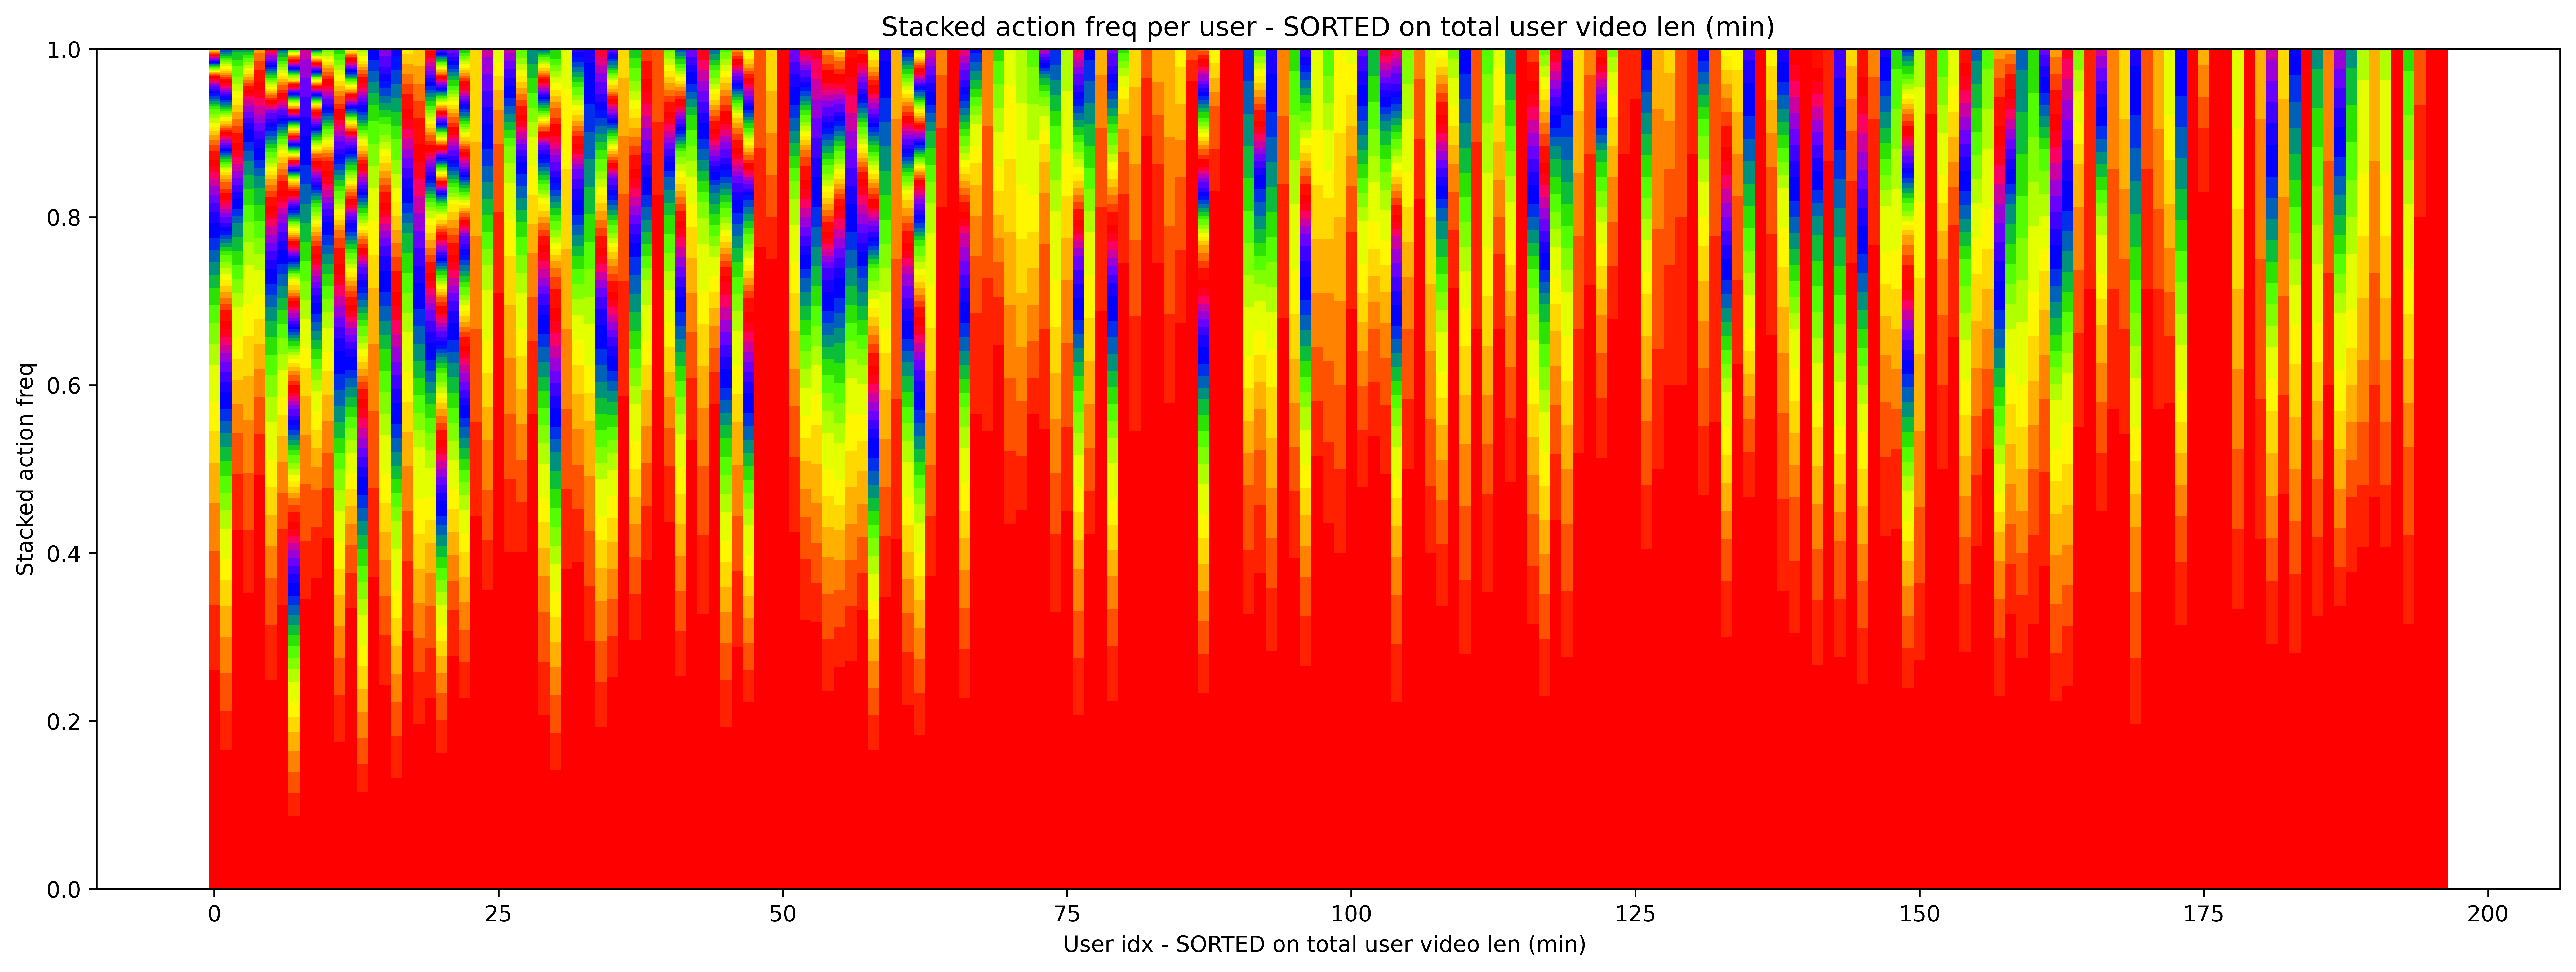

<Figure size 432x288 with 0 Axes>

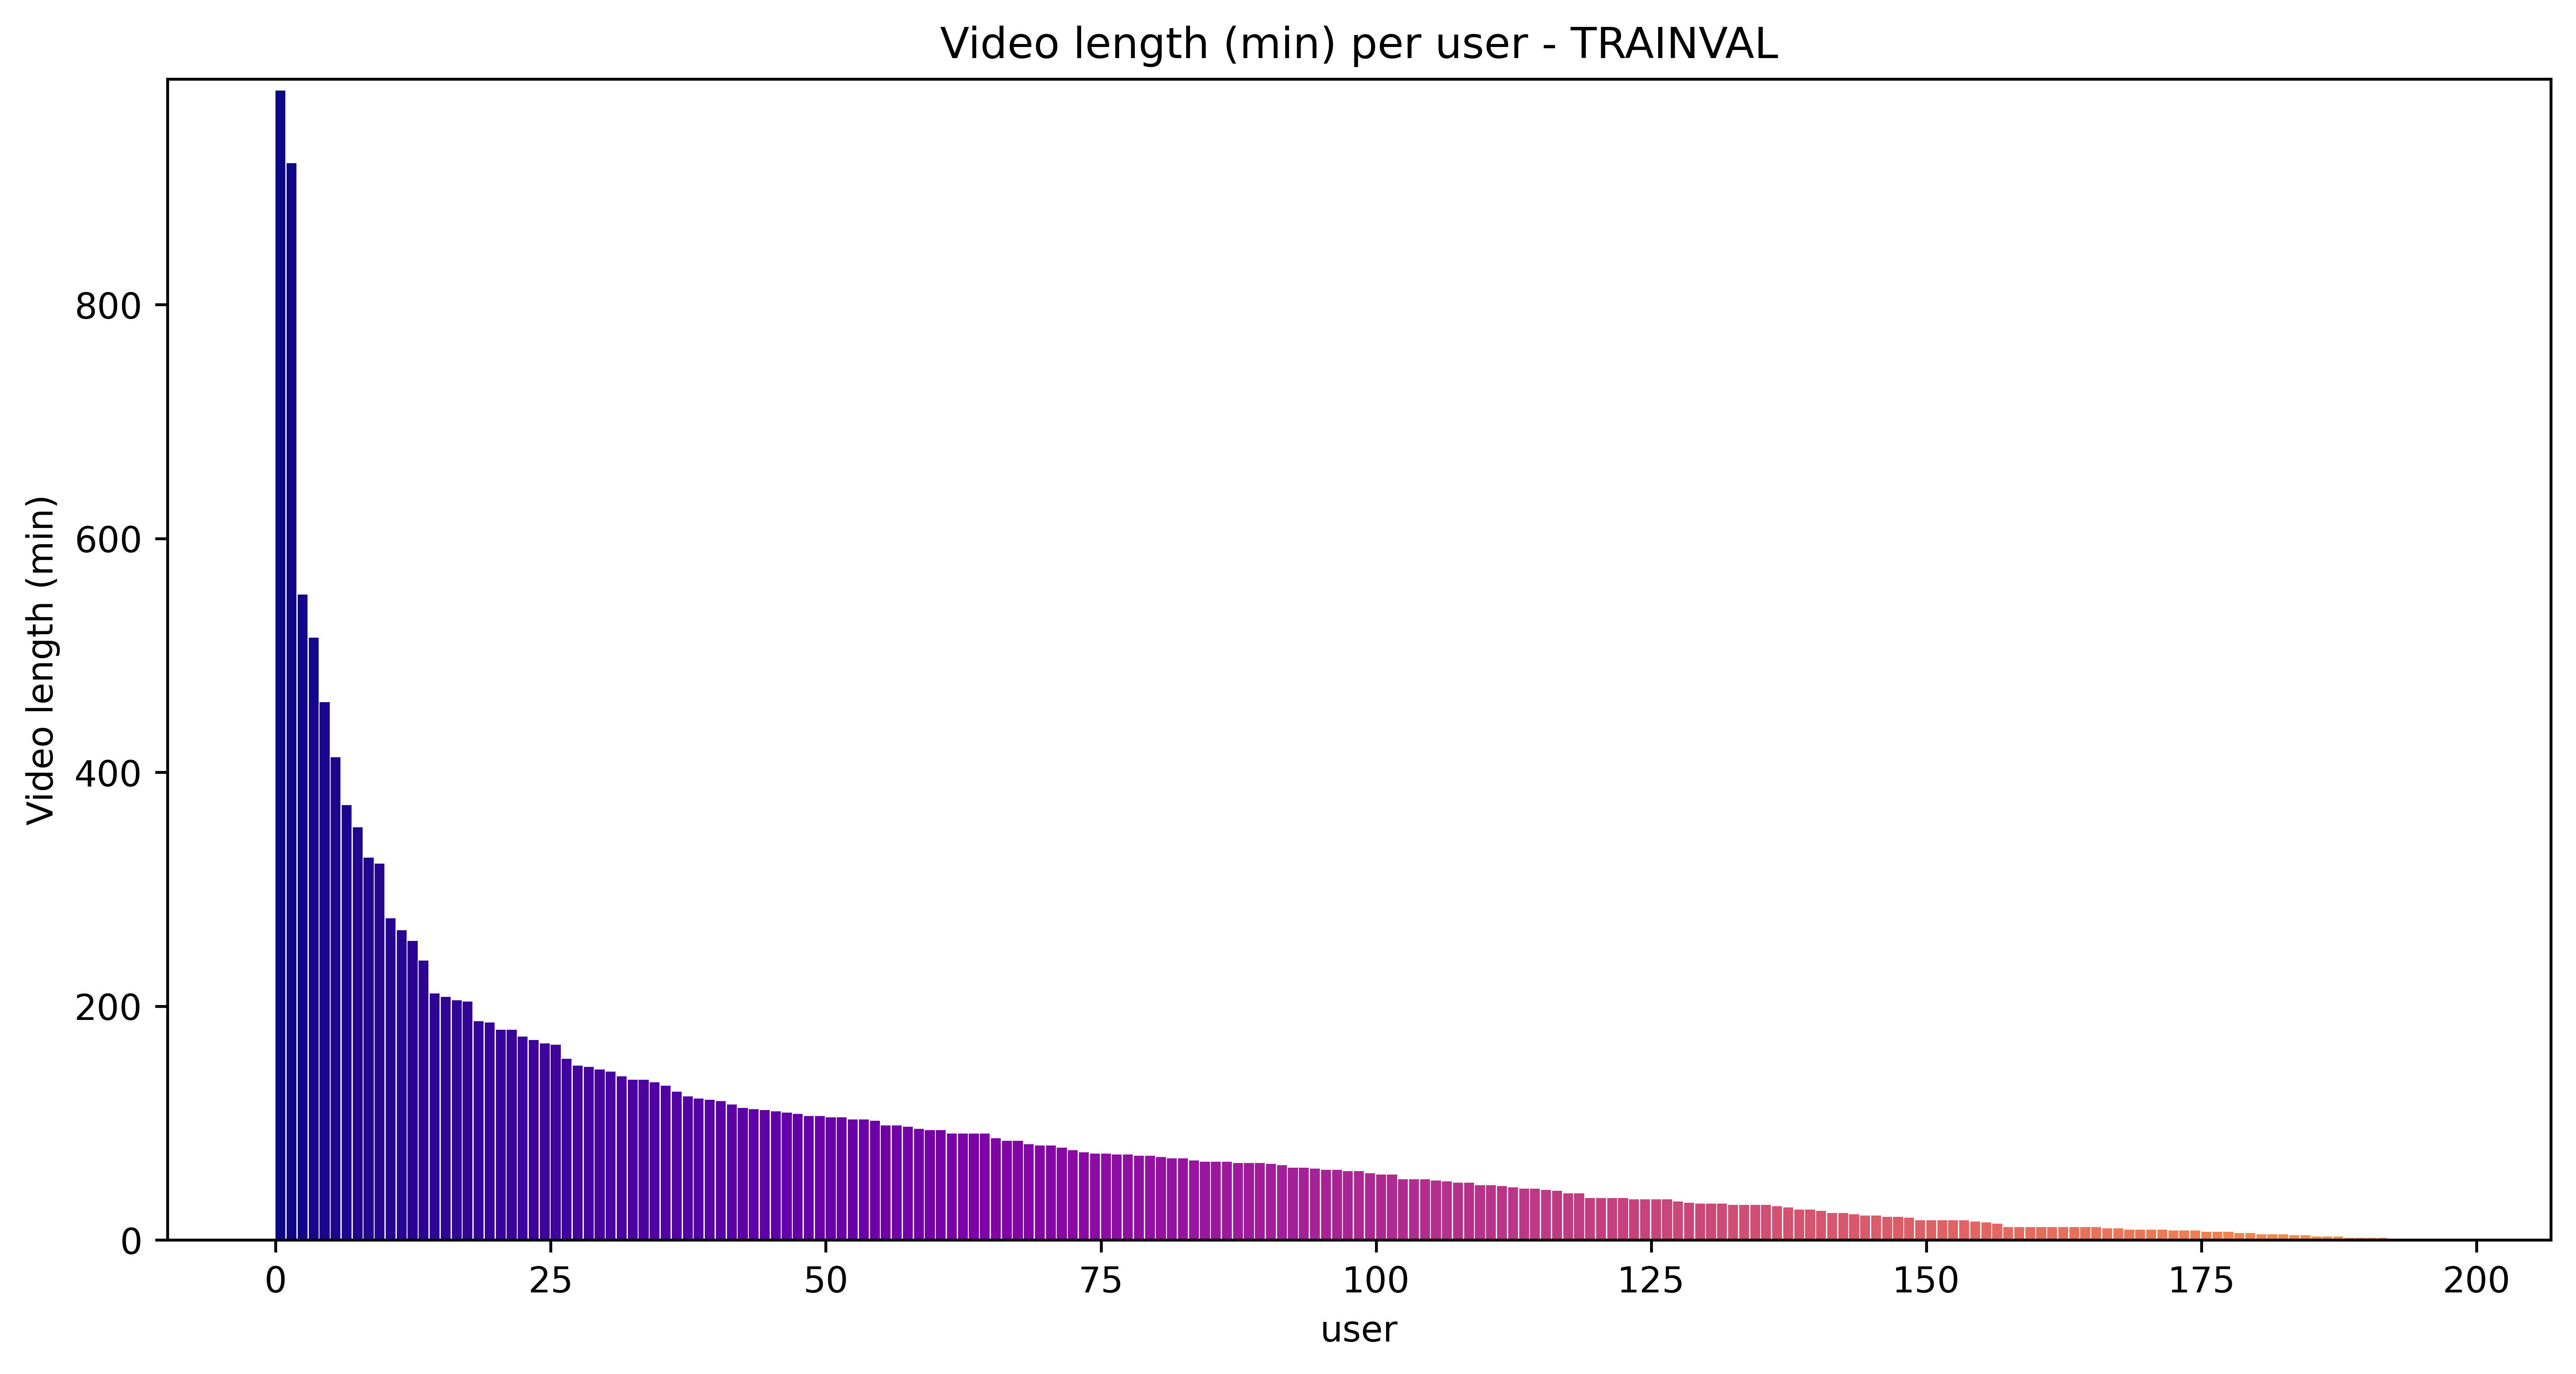

HEAD = [983, 921, 552, 515, 460, 413, 372, 353, 327, 322]...
TAIL = ...[3, 2, 2, 2, 2, 1, 1, 1, 0, 0]


<Figure size 432x288 with 0 Axes>

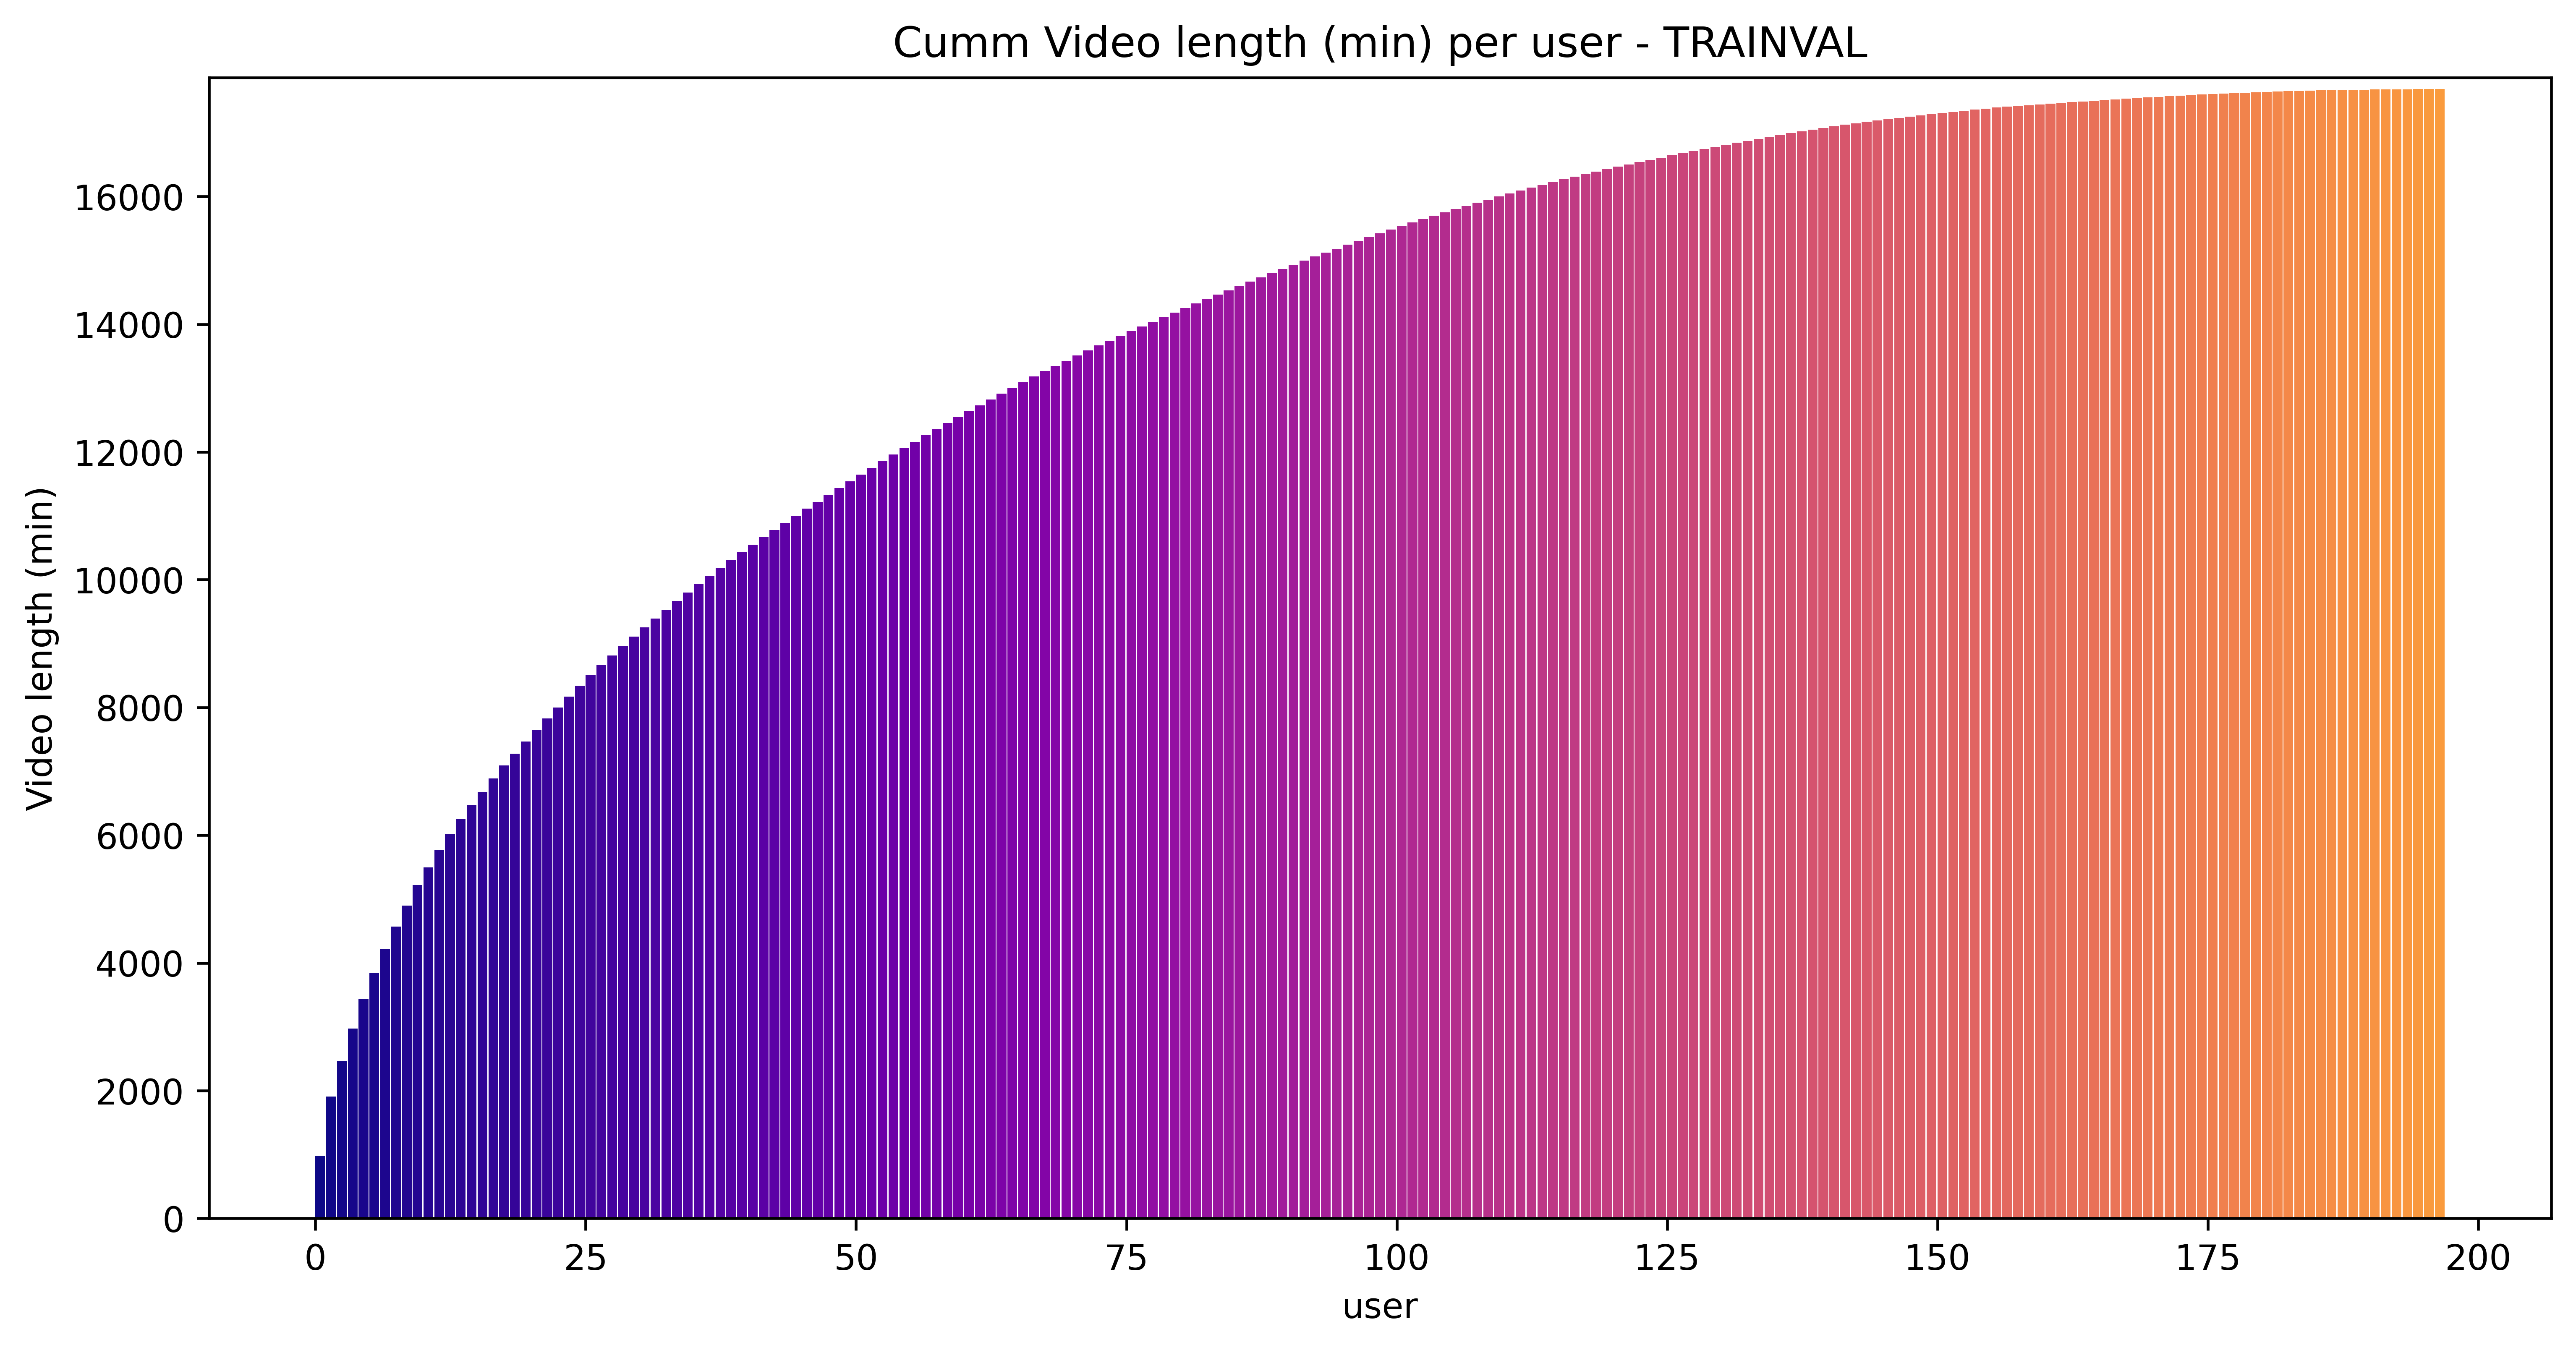

HEAD = [983, 1905, 2457, 2972, 3433, 3846, 4218, 4572, 4899, 5222]...
TAIL = ...[17667, 17670, 17673, 17675, 17677, 17679, 17680, 17681, 17682, 17682]
[983, 1905, 2457, 2972, 3433, 3846, 4218, 4572, 4899, 5222, 5497, 5763, 6020, 6259, 6471, 6679, 6885, 7090, 7278, 7465, 7645, 7825, 7999, 8170, 8339, 8507, 8662, 8812, 8960, 9107, 9251, 9392, 9530, 9667, 9802, 9935, 10062, 10185, 10307, 10427, 10546, 10663, 10776, 10889, 11000, 11110, 11220, 11328, 11435, 11541, 11646, 11752, 11856, 11959, 12062, 12161, 12260, 12357, 12452, 12546, 12641, 12732, 12824, 12916, 13007, 13094, 13180, 13265, 13347, 13429, 13510, 13589, 13667, 13743, 13817, 13892, 13965, 14039, 14111, 14183, 14255, 14325, 14396, 14465, 14532, 14600, 14667, 14734, 14801, 14867, 14932, 14997, 15059, 15122, 15183, 15244, 15304, 15364, 15423, 15481, 15537, 15593, 15646, 15699, 15751, 15802, 15852, 15902, 15951, 15999, 16046, 16092, 16137, 16182, 16226, 16269, 16312, 16352, 16392, 16429, 16465, 16502, 16538, 16574, 16609, 16644, 166

<Figure size 432x288 with 0 Axes>

In [4]:
trainval_video_lens_s = plot_useractions_stackedbarchart(trainval_user_counter_df)

# Plot video total lengths
y_axis = [int(x/60) for x in trainval_video_lens_s]
x_axis = [idx for idx in range(len(trainval_video_lens_s))]
plot_barchart(x_axis, y_axis, title='Video length (min) per user - TRAINVAL',ylabel='Video length (min)',xlabel="user")

# Plot cumulative
y_axis = [int(x/60) for x in np.cumsum(trainval_video_lens_s)]
x_axis = [idx for idx in range(len(trainval_video_lens_s))]
plot_barchart(x_axis, y_axis, title='Cumm Video length (min) per user - TRAINVAL',ylabel='Video length (min)',xlabel="user")
print(y_axis)

# Check for videos without scenarios

In [5]:
# NUMBER OF MISSING LABELS/ MISSING SCENARIO LABELS/ MISSING USER LABEL

# For this we can't use the user-merged DF, we need the full original one
trainval_joined_df

# Group by video_id, rather than user
video_trainval_joined_df = trainval_joined_df.groupby(trainval_joined_df['video_uid'], as_index=False).agg(
    {'verb':list,'noun':list, 'verb_label':list, 'noun_label':list,'clip_id':list,'action_idx':list,'scenarios':list})
video_trainval_joined_df['empty_scenario_count'] = video_trainval_joined_df['scenarios'].apply(lambda x: len(np.concatenate(x))==0)
print(f"Videos with no scenarios: {sum(video_trainval_joined_df['empty_scenario_count'].tolist())}")

Videos with no scenarios: 0


# Distribution over scenarios in Train-Val subset
Both a horizontal and a vertical view.

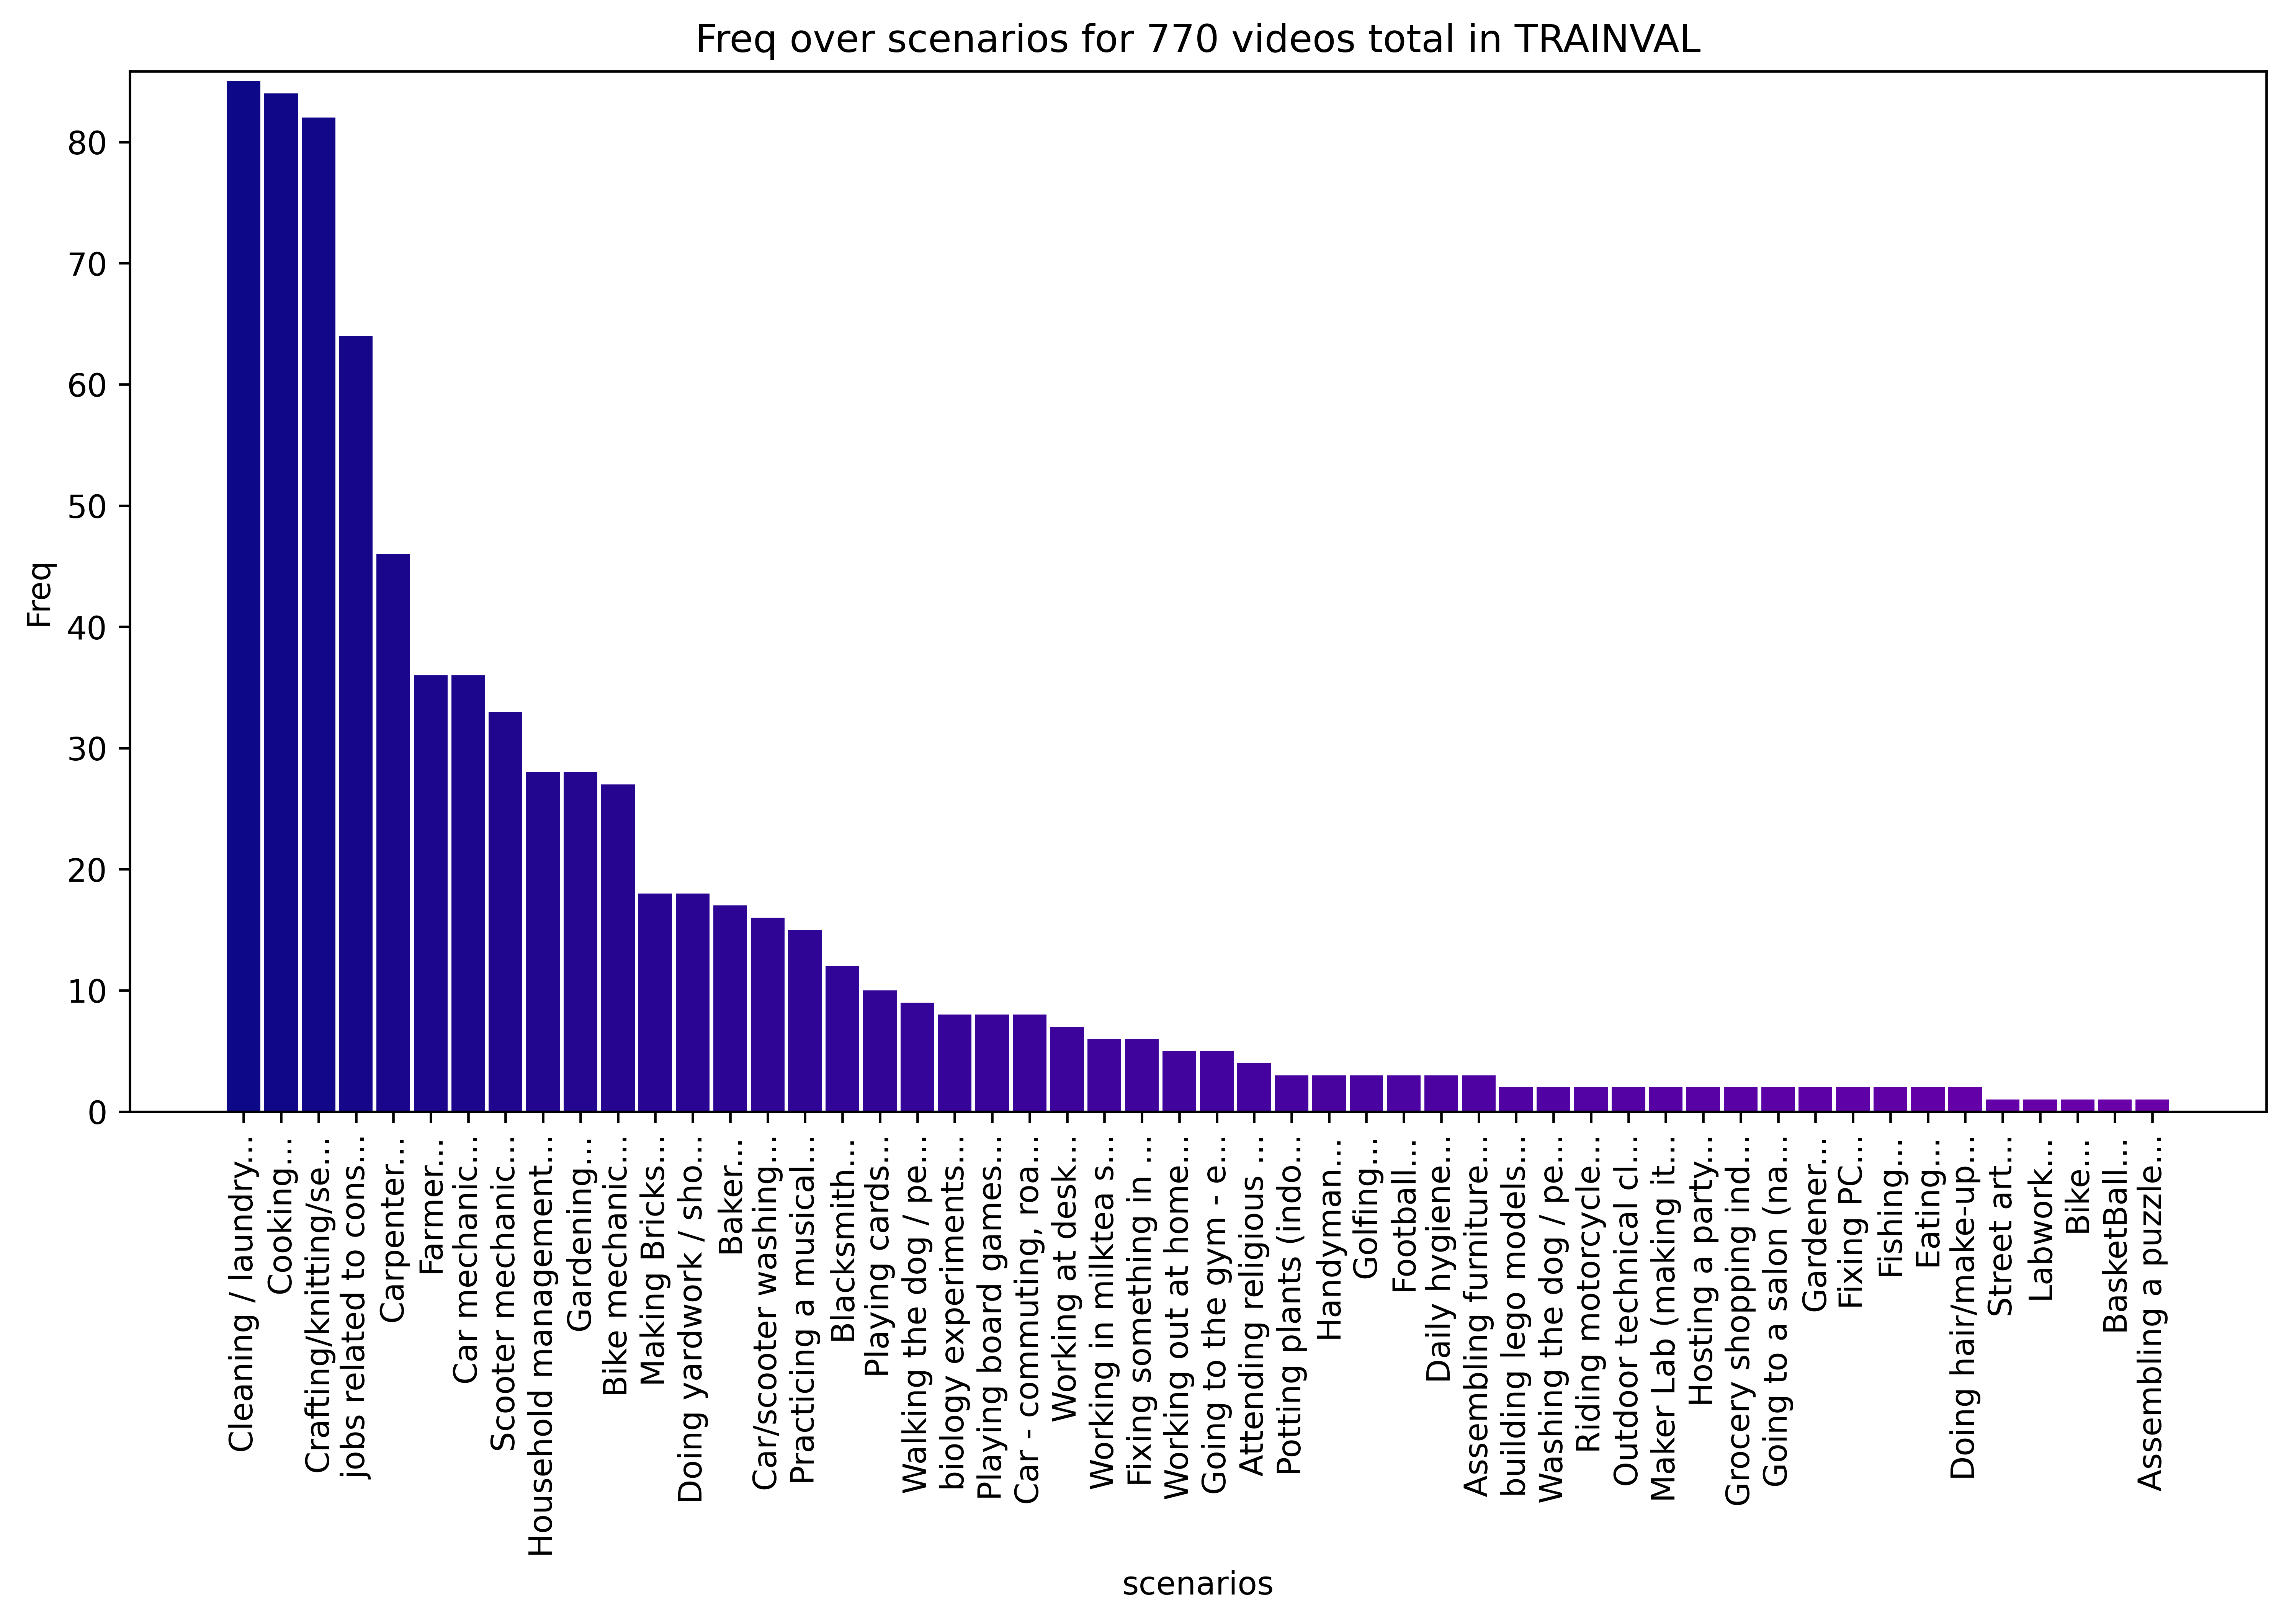

HEAD = [85, 84, 82, 64, 46, 36, 36, 33, 28, 28]...
TAIL = ...[2, 2, 2, 2, 2, 1, 1, 1, 1, 1]


<Figure size 432x288 with 0 Axes>

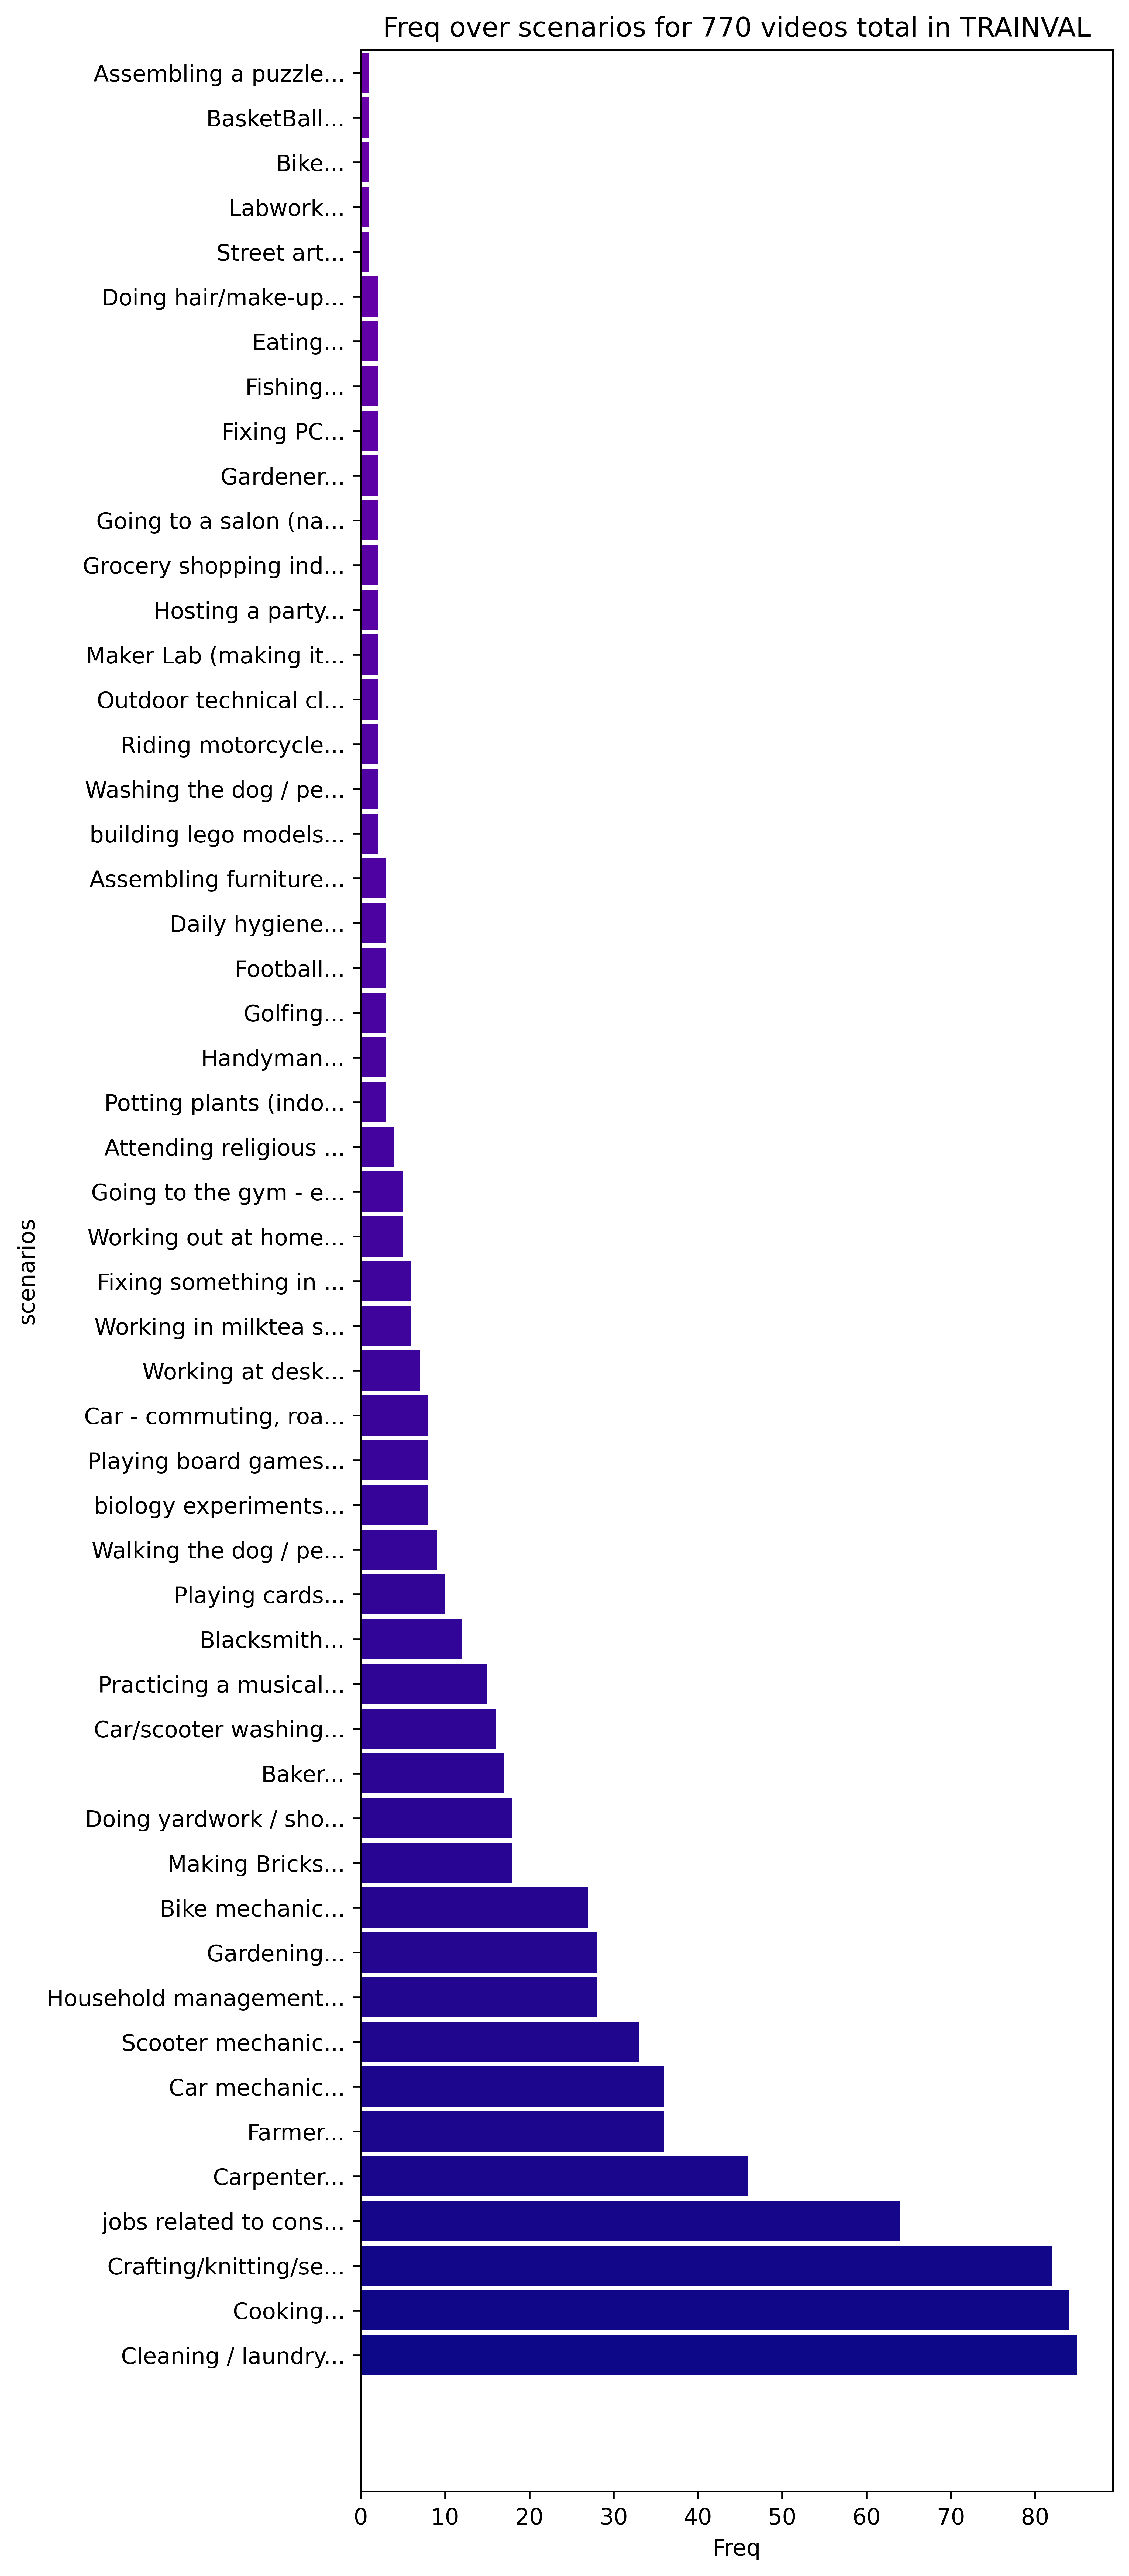

HEAD = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]...
TAIL = ...[42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
['Cleaning / laundry...', 'Cooking...', 'Crafting/knitting/se...', 'jobs related to cons...', 'Carpenter...', 'Farmer...', 'Car mechanic...', 'Scooter mechanic...', 'Household management...', 'Gardening...', 'Bike mechanic...', 'Making Bricks...', 'Doing yardwork / sho...', 'Baker...', 'Car/scooter washing...', 'Practicing a musical...', 'Blacksmith...', 'Playing cards...', 'Walking the dog / pe...', 'biology experiments...', 'Playing board games...', 'Car - commuting, roa...', 'Working at desk...', 'Working in milktea s...', 'Fixing something in ...', 'Working out at home...', 'Going to the gym - e...', 'Attending religious ...', 'Potting plants (indo...', 'Handyman...', 'Golfing...', 'Football...', 'Daily hygiene...', 'Assembling furniture...', 'building lego models...', 'Washing the dog / pe...', 'Riding motorcycle...', 'Outdoor technical cl...', 'Maker Lab (making it...', 'Hosting a party...

<Figure size 432x288 with 0 Axes>

In [6]:
# TRAINVAL distr of scenarios
video_trainval_joined_df = trainval_joined_df.groupby(trainval_joined_df['video_uid'], as_index=False).agg(
    {'verb':list,'noun':list, 'verb_label':list, 'noun_label':list,'clip_id':list,'action_idx':list,'scenarios':'first'})
# Each video can have multiple scenarios (see meta-data object)
# Let's see agnostic from the video what the distr over scenarios is

# Keep only videos that are in the TRAINVAL subset
trainval_video_df = video_df.loc[video_df['video_uid'].isin(trainval_joined_df['video_uid'])]
# 770 rows × 54 columns
scenario_counter = Counter(np.concatenate(trainval_video_df['scenarios'].tolist()))
# df.loc[df['column_name'].isin(some_values)]

scenario_counter_s = sorted([(value,key) for key,value in scenario_counter.items()],reverse=True)

label_len_cutoff =  20
y_axis = [x[0] for x in scenario_counter_s]
x_labels = [x[1] for x in scenario_counter_s] # Cutoff long labels
x_labels = [x[:label_len_cutoff] + "..." for x in x_labels] # Cutoff long labels
x_axis = [idx for idx in range(len(scenario_counter_s))]
plot_barchart(x_axis, y_axis, title='Freq over scenarios for 770 videos total in TRAINVAL',ylabel='Freq',xlabel="scenarios",x_labels=x_labels,bar_align='center')


# Make reversed plot
plot_barchart(y_axis, x_axis, title='Freq over scenarios for 770 videos total in TRAINVAL',xlabel='Freq',ylabel="scenarios",y_labels=x_labels,bar_align='center',barh=True,figsize=(6,20))
print(x_labels)

from pprint import pprint
pprint(x_labels)